# Working with the GDP hourly dataset of position, velocity, and temperature

This notebook is intended to get you started on working with the GDP hourly dataset, version 2.00. We provide some examples of what can be done with this dataset. This notebook was put together by [Shane Elipot](https://github.com/selipot) and [Philippe Miron](https://github.com/philippemiron).

The dataset is officially distributed by [NOAA NCEI](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:AOML-GDP-1HR) as a single file (`gdp_v2.00.nc`, ~13GB) which can be downloaded directly to your computer using this [link](https://www.nodc.noaa.gov/archive/arc0199/0248584/1.1/data/0-data/). 

This dataset is also distributed as an [open dataset on the AWS cloud storage](https://registry.opendata.aws/noaa-oar-hourly-gdp/). You can explore freely this [S3 bucket](https://noaa-oar-hourly-gdp-pds.s3.amazonaws.com/index.html) and download the version of the file you need: under `ncei/` you will find exactly the same file as in the NOAA NCEI repository, while under `latest/` you will find the same data but with updated metadata and organization. We recommend that you use any of these files in `latest/`. You will also find there different file format of the same data (netCDF, parquet, or zarr).

The good news and that you don't have to download directly and completely the data file, you can simply open them "over HTTP", as an example using the proper syntax with the python *xarray* library, as shown below. 

When using this dataset in your studies or publications, please use the following citation:

- Elipot, Shane; Sykulski, Adam; Lumpkin, Rick; Centurioni, Luca; Pazos, Mayra (2022). *Hourly location, current velocity, and temperature collected from Global Drifter Program drifters world-wide*.[indicate subset used]. NOAA National Centers for Environmental Information. Dataset. https://doi.org/10.25921/x46c-3620. Accessed [date].

Additionally, we would be very grateful if you could cite the papers describing how the dataset were derived. If you use the dataset of position and velocity, please cite:

- Elipot, S., R. Lumpkin, R. C. Perez, J. M. Lilly, J. J. Early, and A. M. Sykulski (2016), *A global surface drifter dataset at hourly resolution*, J. Geophys. Res. Oceans, 121, [doi:10.1002/2016JC011716](https://dx.doi.org/10.1002/2016JC011716).

And if you use the dataset of sea surface temperature, please cite:

- Elipot, S., A. Sykulski, R. Lumpkin, L. Centurioni, and M. Pazos (2022), *A Dataset of Hourly Sea Surface Temperature From Drifting Buoys*, Scientific Data, 9, 567, [doi:10.1038/s41597-022-01670-2](https://dx.doi.org/10.1038/s41597-022-01670-2).

### Opening the dataset with *xarray*:

In [42]:
#import the needed libraries
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

Here we propose two options: you have either downloaded the data file and have it somewhere on your computer (option 1), or you open it remotely (option2). This last option may be slow depending on your internet connection. Comment and uncomment as needed below:

In [43]:
file = 'gdp_v2.00.nc'

# # option 1: open locally after downloading the file. 
# path = '/Users/selipot/Downloads/'
# ds = xr.open_dataset(path+file)

# option 2: open the file over HTTP without downloading. This is accomplished by appending #mode=bytes to the data file URL
# if you use the NCEI link, or the ncei/ path of the AWS bucket, the geographical coordinates are called "longitude" and "latitude" 
#  but otherwise they are called lon and lat. Modify the code below accordingly.
# url_path = 'https://www.nodc.noaa.gov/archive/arc0199/0248584/1.1/data/0-data/'
url_path = 'https://noaa-oar-hourly-gdp-pds.s3.amazonaws.com/latest/'
ds = xr.open_dataset(url_path+file+'#mode=bytes')

In [44]:
ds

<xarray.Dataset>
Dimensions:                (traj: 17324, obs: 165754333)
Coordinates:
    ids                    (obs) int64 ...
    time                   (obs) datetime64[ns] ...
    lon                    (obs) float32 ...
    lat                    (obs) float32 ...
Dimensions without coordinates: traj, obs
Data variables: (12/55)
    ID                     (traj) int64 ...
    rowsize                (traj) int32 ...
    WMO                    (traj) int32 ...
    expno                  (traj) int32 ...
    deploy_date            (traj) datetime64[ns] ...
    deploy_lat             (traj) float64 ...
    ...                     ...
    err_sst1               (obs) float64 ...
    err_sst2               (obs) float64 ...
    flg_sst                (obs) int8 ...
    flg_sst1               (obs) int8 ...
    flg_sst2               (obs) int8 ...
    drogue_status          (obs) bool ...
Attributes: (12/16)
    title:             Global Drifter Program hourly drifting buoy collection
    history:           Version 2.00.  Metadata from dirall.dat and deplog.dat
    Conventions:       CF-1.6
    date_created:      2022-12-09T06:02:29.684949
    publisher_name:    GDP Drifter DAC
    publisher_email:   aoml.dftr@noaa.gov
    ...                ...
    contributor_name:  NOAA Global Drifter Program
    contributor_role:  Data Acquisition Center
    institution:       NOAA Atlantic Oceanographic and Meteorological Laboratory
    acknowledgement:   Elipot, Shane; Sykulski, Adam; Lumpkin, Rick; Centurio...
    summary:           Global Drifter Program hourly data
    doi:               10.25921/x46c-3620

Here the dataset is opened as a `xarray.Dataset` object. The dataset contains the dimension `traj` which is equal to the number of trajectories (17324 for v2.00). The variables with this dimension correspond to what may be referred to as *metadata* such as the buoy type (`buoy_type`), the deployment date (`deploy_date`) etc. The other Lagrangian variables (velocity, position, SST, etc.) along the 17324 trajectories are stored one after the other along the `obs` dimension.  In order to track the length of each consecutive drifter trajectory, an array variable called `rowsize` contains the trajectory lengths. Note that for practical reasons, the identification numbers, or IDs, of the drifters are both found in the `ID` variable with dimension `traj` and the `ids` variable with dimension `obs`. This last Lagrangian variable can also be used to keep track of individual trajectories. 

### A simple Lagrangian plot:

Let's consider a simple use of the data: let's say we want to plot the trajectory of drifter with ID number 2578 with the non-diurnal SST displayed along the trajectory. 

To do this, we  need to find the indices of the data for that drifter thanks to the `rowsize` variable. With an *xarray* dataset, we need to create first a variable that indexes the beginning of each trajectory: we create an array `traj_idx` in which `traj_idx[i]` is the starting index of the data for the (i+1)<sup>th</sup> trajectory (since *Python* uses zero-based indexing.).

In [45]:
# create the index array
traj_idx = np.insert(np.cumsum(ds.rowsize.values), 0, 0)

In [46]:
n = 2578
# find the index for drifter ID 2578
j = int(np.where(ds.ID==n)[0])
display('drifter index for ID '+str(n)+' is '+str(j))
ds.sst1[slice(traj_idx[j], traj_idx[j+1])]

'drifter index for ID 2578 is 0'

<xarray.DataArray 'sst1' (obs: 5137)>
[5137 values with dtype=float64]
Coordinates:
    ids      (obs) int64 ...
    time     (obs) datetime64[ns] ...
    lon      (obs) float32 ...
    lat      (obs) float32 ...
Dimensions without coordinates: obs
Attributes:
    long_name:  Fitted non-diurnal sea water temperature
    units:      Kelvin
    comments:   Estimated near-surface non-diurnal sea water temperature from...

Above we peaked at the `sst1` variable for this particular drifter. Note that the unit of this variable is the Kelvin. See [Elipot et al. 2022](https://doi.org/10.1038/s41597-022-01670-2
) for details about the hourly temperature dataset for the GDP.

In [47]:
# create the slice index `sli` for data from that drifter
sli = slice(traj_idx[j], traj_idx[j+1])
display(sli)
# also we want to know the minimum and maximum values in degrees Celsius of the good data (quality flag 4 and 5)
v1 = ds.sst1[sli].where(ds.flg_sst1[sli]>=4).min()-273.15
v2 = ds.sst1[sli].where(ds.flg_sst1[sli]>=4).max()-273.15
display([v1,v2])

slice(0, 5137, None)

[<xarray.DataArray 'sst1' ()>
 array(-1.766),
 <xarray.DataArray 'sst1' ()>
 array(22.463)]

Now we are ready to plot the trajectory:

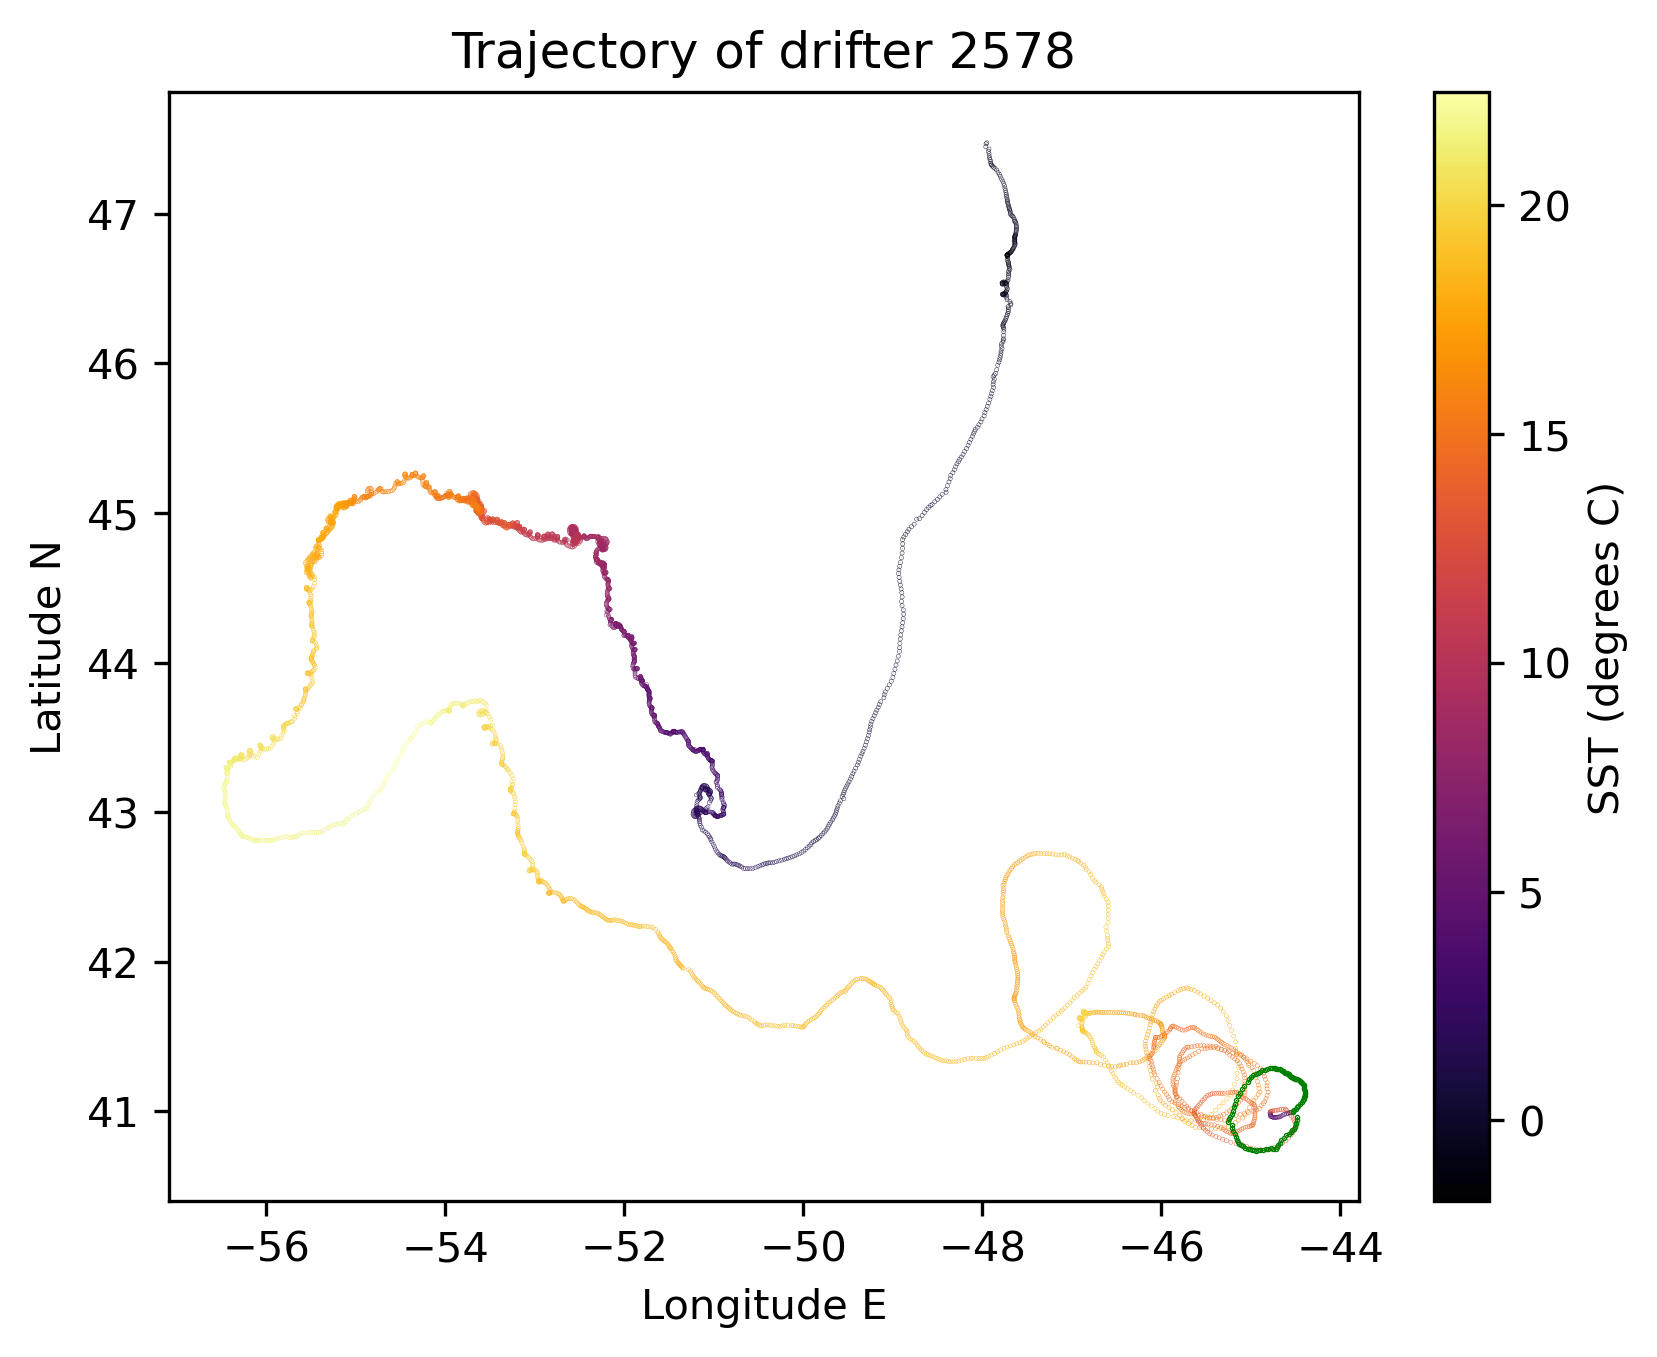

In [48]:
fig = plt.figure(dpi=300) 
ax = fig.add_subplot(1,1,1)
#fig, ax = plt.subplots(1)
# temperature data are in Kelvin so we convert to degree Celsius
# we plot only the non-diurnal SST estimates (sst1) with quality flag (flg_sst1) 4 or 5. 
pcm1 = ax.scatter(ds.lon[sli].where(ds.flg_sst1[sli]>=4), ds.lat[sli].where(ds.flg_sst1[sli]>=4),
                 s=0.01, c=ds.sst1[sli].where(ds.flg_sst1[sli]>=4)-273.15,vmin=v1, vmax=v2,cmap='inferno',edgecolor='face')
# we plot the other positions with "bad" SST estimates in green (quality flag less than 4)
pcm2 = ax.scatter(ds.lon[sli].where(ds.flg_sst1[sli]<4), ds.lat[sli].where(ds.flg_sst1[sli]<4),
                 s=0.1, c='green')
cb = fig.colorbar(pcm1,ax=ax)
cb.set_label('SST (degrees C)')
ax.set_ylabel('Latitude N')
ax.set_xlabel('Longitude E')
ax.set_title('Trajectory of drifter '+str(n));

### A time series plot:

Next we want to plot the time series of eastward (`ve` or zonal, u) and northward (`vn` or meridional, v) velocities along this drifter trajectory:

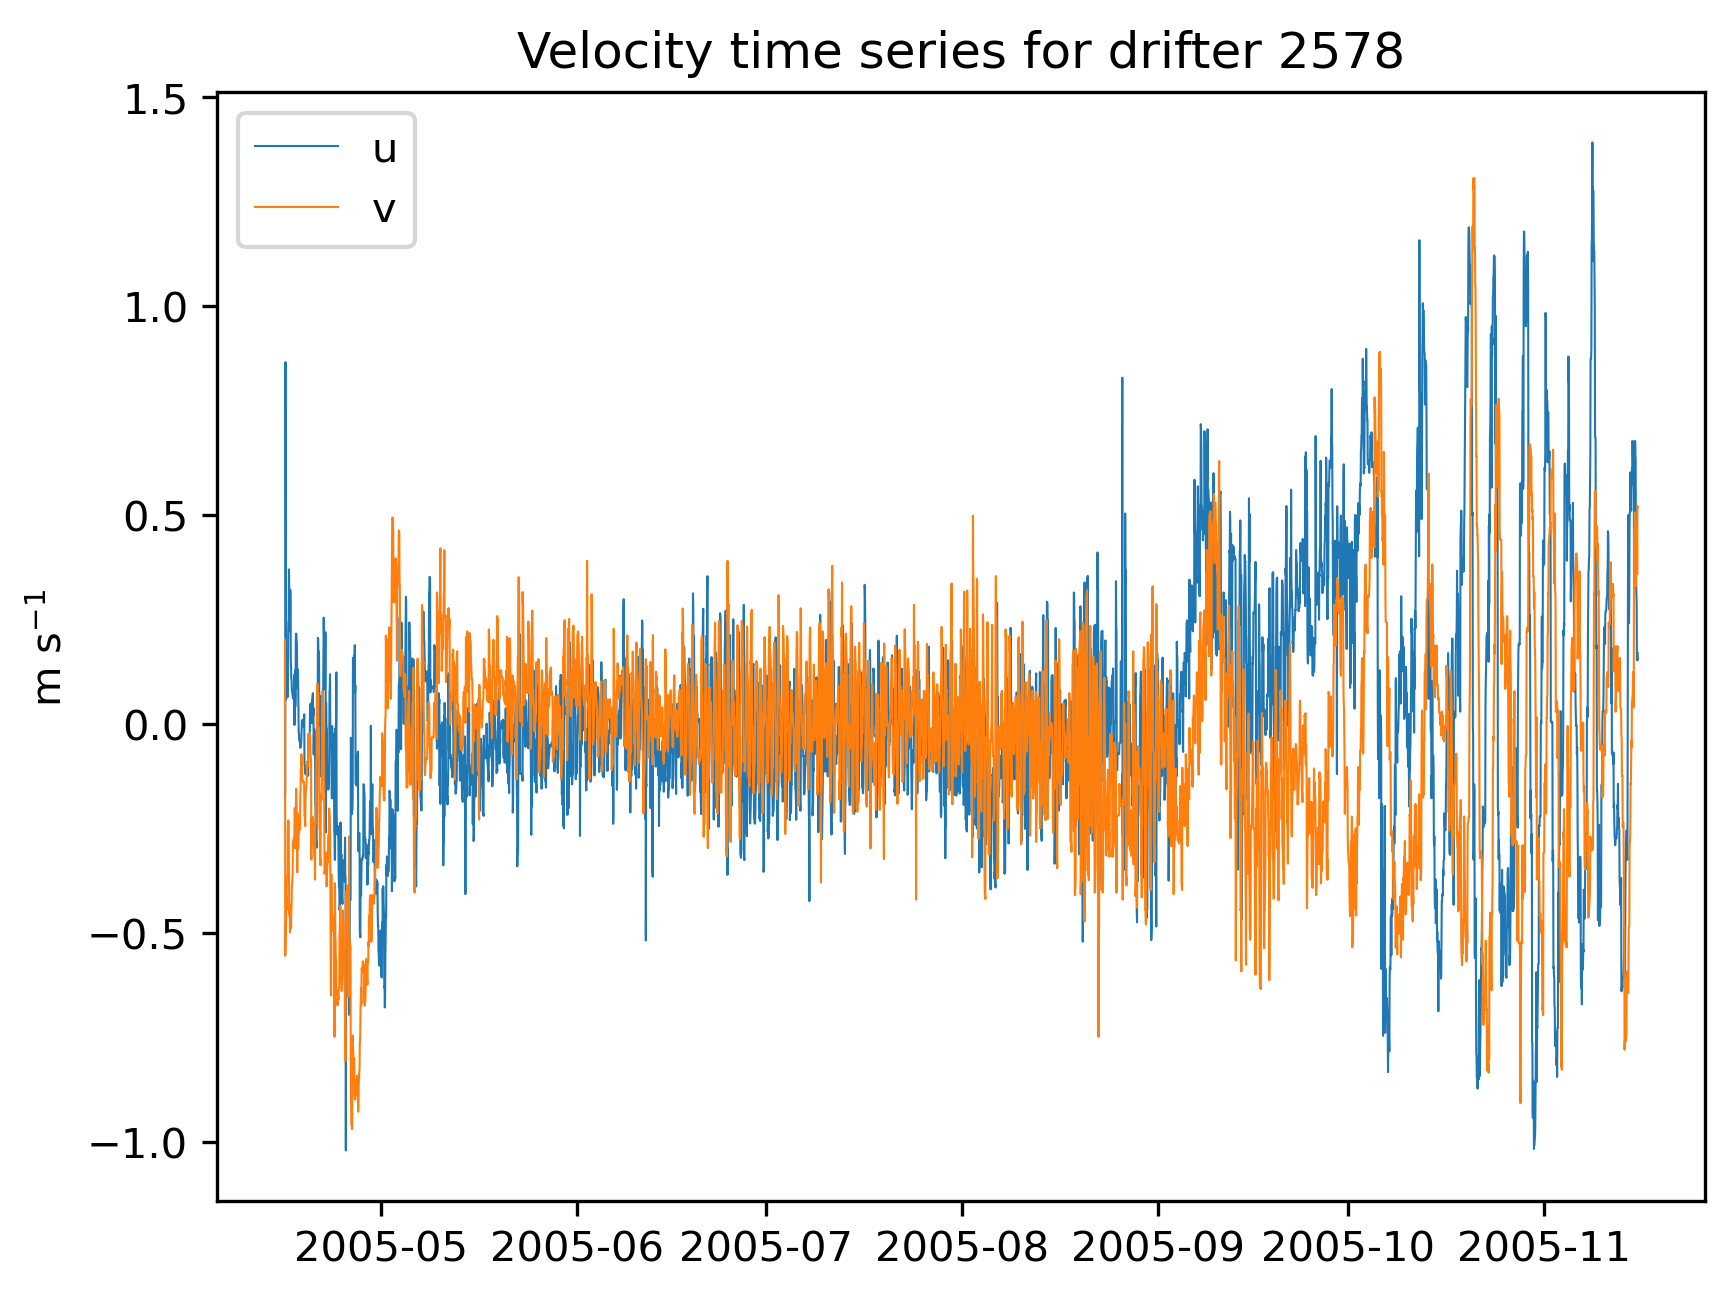

In [49]:
fig = plt.figure(dpi=300) 
ax = fig.add_subplot(1,1,1)
pcm1 = ax.plot(ds.time[sli],ds.ve[sli],linewidth=0.5)
pcm2 = ax.plot(ds.time[sli],ds.vn[sli],linewidth=0.5)
ax.legend(['u', 'v'])
ax.set_ylabel('m s$^{-1}$')
ax.set_title('Velocity time series for drifter '+str(n));

Plenty more can be done with these data! If you want to see more example, head to this other [notebook](https://github.com/Cloud-Drift/earthcube-meeting-2022) that benchmark various python libraries that can be used to work with this dataset.

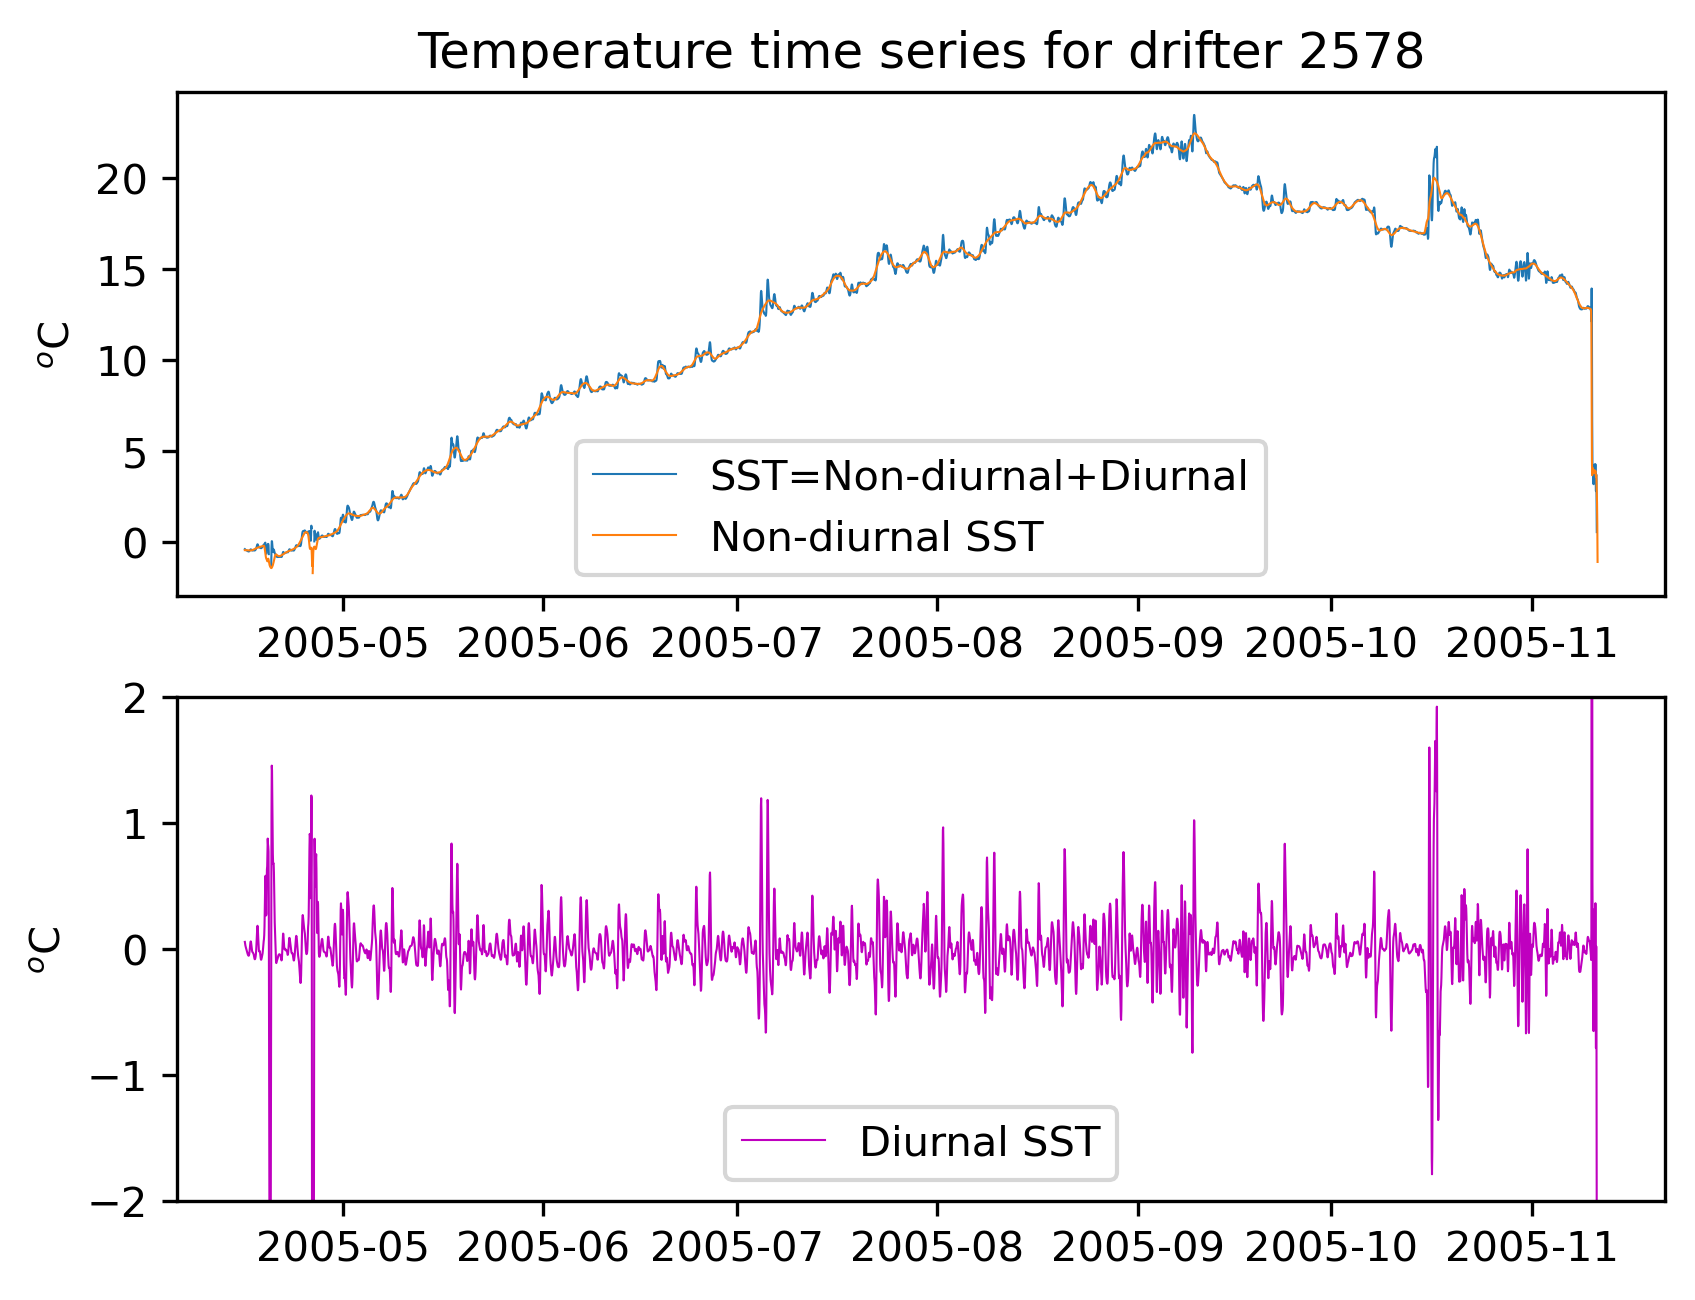

In [50]:
fig = plt.figure(dpi=300) 
ax = fig.add_subplot(2,1,1)
pcm1 = ax.plot(ds.time[sli],ds.sst[sli].where(ds.flg_sst[sli]==5)-273.15,linewidth=0.5)
pcm2 = ax.plot(ds.time[sli],ds.sst1[sli].where(ds.flg_sst1[sli]==5)-273.15,linewidth=0.5)
ax.legend(['SST=Non-diurnal+Diurnal', 'Non-diurnal SST'])
ax.set_ylabel('$^o$C')
ax.set_title('Temperature time series for drifter '+str(n));
ax = fig.add_subplot(2,1,2)
pcm1 = ax.plot(ds.time[sli],ds.sst2[sli].where(ds.flg_sst1[sli]==5),linewidth=0.5,color='m')
ax.set_ylabel('$^o$C')
ax.set_ylim(-2,2)
ax.legend(['Diurnal SST'])
